In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

## Генерация данных

In [10]:
# Мультипликативность через произведение

# def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True):
#     if random_seed:
#         np.random.seed(random_seed)
        
#     signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
#     noise = np.random.normal(0,0.1,ts_length)
#     signal = signal+noise

#     change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0]
#     change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
#     change_point_value = np.random.normal(0.5,0.1,1)*np.random.choice([-1,1],1,)[0]
#     if is_multiplicative:
#         change_point_mult_value = 1+change_point_value
#     else:
#         change_point_mult_value = 1
    
#     if change_point:
#         signal[change_point:] = (signal[change_point:]+change_point_value) * change_point_mult_value
#     else:
#         change_point_value = None
#     return([signal, change_point, change_point_value])

In [2]:
# Мультипликативность через экспоненту

def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True):
    if random_seed:
        np.random.seed(random_seed)
        
    signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
    noise = np.random.normal(0,0.5,ts_length)
    signal = signal+noise

    change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0]
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    change_point_value = np.random.normal(0,3,1)*np.random.choice([-1,1],1,)[0]
    
    if change_point:
        signal[change_point:] = signal[change_point:]+change_point_value
        if is_multiplicative:
            signal = np.exp(signal)
    else:
        change_point_value = None
    return([signal, change_point, change_point_value])

array([4.63464307])

Пример работы (с мультипликативностью и без)

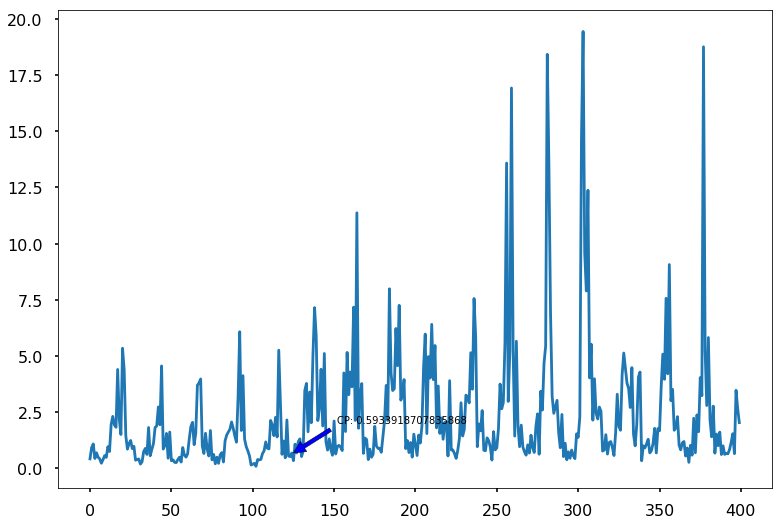

In [8]:
generated = data_generator(is_multiplicative = True, random_seed=100)
plt.plot(generated[0])
plt.annotate('CP: {}'.format(generated[2][0]), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]+30, 2), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.show()


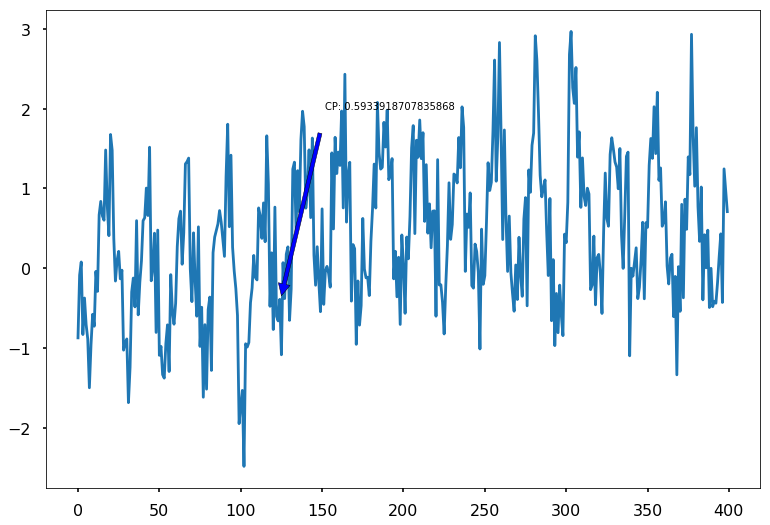

In [9]:
generated = data_generator(is_multiplicative = False, random_seed=100)
plt.plot(generated[0])
plt.annotate('CP: {}'.format(generated[2][0]), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]+30, 2), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.show()


## Методы обнаружения разладки

In [99]:
# Старый медленный способ
# def approximation_mean(time_series, window, threshold=None, mode = 0):
# #     time_series = n p.array(time_series)
#     if window%2 != 0:
#         window += 1
#     result = [np.nan]*(window-1)
#     norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)
#     for i in range(len(time_series) - window + 1):
#         all_ts = time_series[i:i+window]
#         left_ts = time_series[i:int(i+window/2)]
#         right_ts = time_series[int(i+window/2):i+window]
        
#         all_ts_cost = np.sum((all_ts - np.mean(all_ts))**2)
#         left_ts_cost = np.sum((left_ts - np.mean(left_ts))**2)
#         right_ts_cost = np.sum((right_ts - np.mean(right_ts))**2)
        
#         result.append((all_ts_cost - left_ts_cost - right_ts_cost)/norm)
        
#         if mode == 1:
#             if max(result) >= threshold:
#                 break
        
#     return(result)

In [11]:
def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

In [12]:
def approximation_mean(time_series, window, threshold=None, mode = 0):
#     time_series = n p.array(time_series)
    if window%2 != 0:
        window += 1
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)
    
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

In [13]:
def cp_detection(cost_values, threshold):
    temp_list = [cost_value > threshold for cost_value in cost_values]
    if np.sum(temp_list) > 0:
        cp_value = [cost_value > threshold for cost_value in cost_values].index(True)
    else:
        cp_value = None
    return(cp_value)    

Проверка, что быстрый метод работает корректно

In [15]:
# [round(x,10) for x in approximation_mean(generated[0], 48) if not np.isnan(x)] == [round(x,10) for x in approximation_mean_fast(generated[0], 48) if not np.isnan(x)]

## Оценка качества метода

In [127]:
def cp_quality(actual, predicted, max_delay = 24):
    df = pd.DataFrame({'actual':actual, 'predicted':predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['predicted'] >= df['actual']), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['predicted'] >= df['actual']), 'delay'] = delay
    
    df.loc[df['actual'] >= 0, 'actual_binary'] = 1
#     df.loc[(df['predicted'] >= 0), 'predicted_binary'] = 1
    df.loc[(df['predicted'] >= 0) & (df['predicted'] >= df['actual']) & (df['delay'] <= max_delay), 'predicted_binary'] = 1
    df[['actual_binary','predicted_binary']] = df[['actual_binary','predicted_binary']].fillna(0)
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'])
    
    return(conf_m, delay) 

### Применим для 1 000 рядов с фиксированным порогом и посмотрим на распределение задержек

In [139]:
%%time
act, pred = [], []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    cp_2 = cp_detection(cp_1, 0.15)
    act.append(generated[1])
    pred.append(cp_2)
    
cp_result = cp_quality(act, pred, 24)

CPU times: user 707 ms, sys: 14.7 ms, total: 722 ms
Wall time: 748 ms


[[220   0]
 [182 598]]


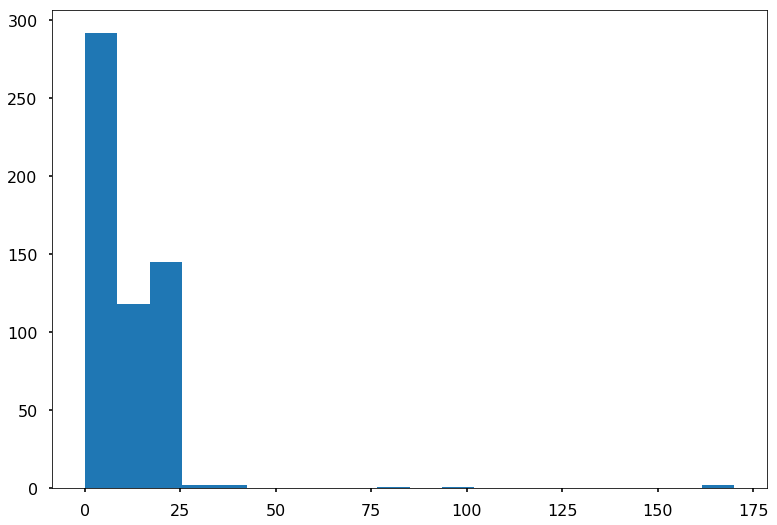

In [18]:
print(cp_result[0])

plt.hist(cp_result[1], bins = 20)
plt.show()

### Пример одного из сгенерированных рядов

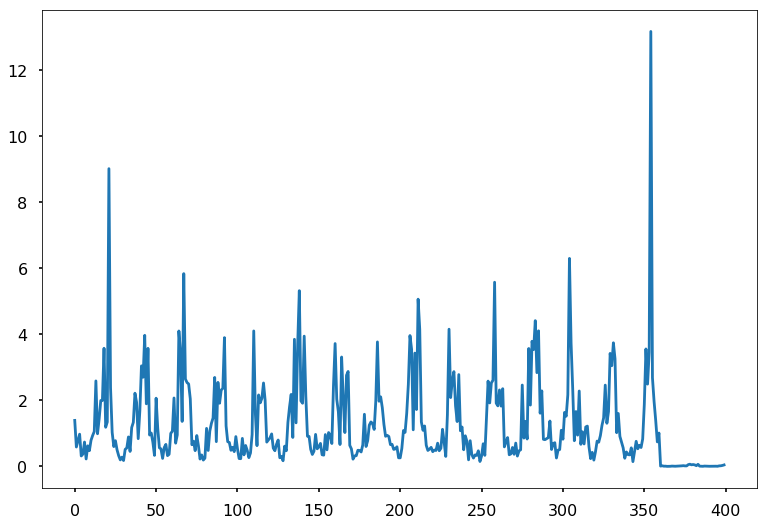

In [19]:
plt.plot(generated[0])
plt.show()

### Функция разладки для этого ряда

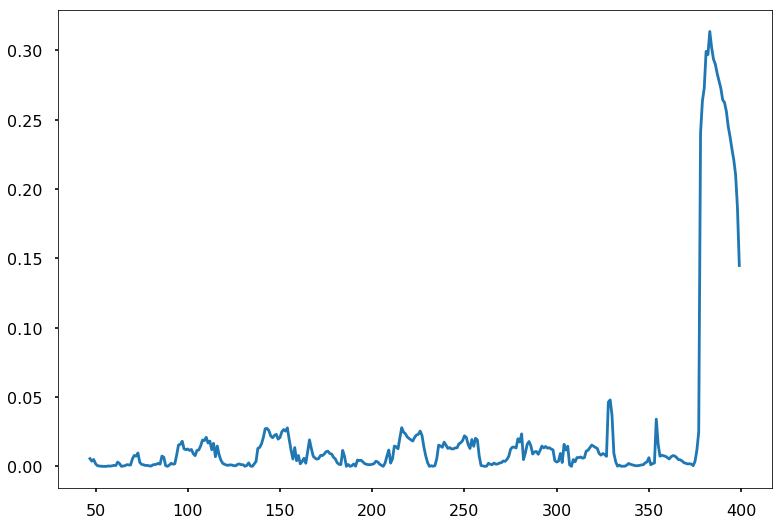

In [20]:
plt.plot(cp_1)
plt.show()

In [58]:
%%time
# df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])
threshold_list = [x/100 for x in range(100)]
act_temp, pred_temp, tr_temp = [], [], []
for i in range(1000): 
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    for tr in threshold_list:
        cp_2 = cp_detection(cp_1, tr)
        act_temp.append(generated[1])
        pred_temp.append(cp_2)
        tr_temp.append(tr)
#         df_cp = df_cp.append({'actual': generated[1], 'predicted': cp_2, 'threshold': tr}, ignore_index=True)
     
df_cp = pd.DataFrame({'actual': act_temp, 'predicted': pred_temp, 'threshold': tr_temp})


CPU times: user 14 s, sys: 48.4 ms, total: 14.1 s
Wall time: 14.1 s


In [59]:
df_cp.shape

(100000, 3)

In [60]:
precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    
    precision.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
    recall.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
    specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])
    
unspecificity = [1-x for x in specificity]

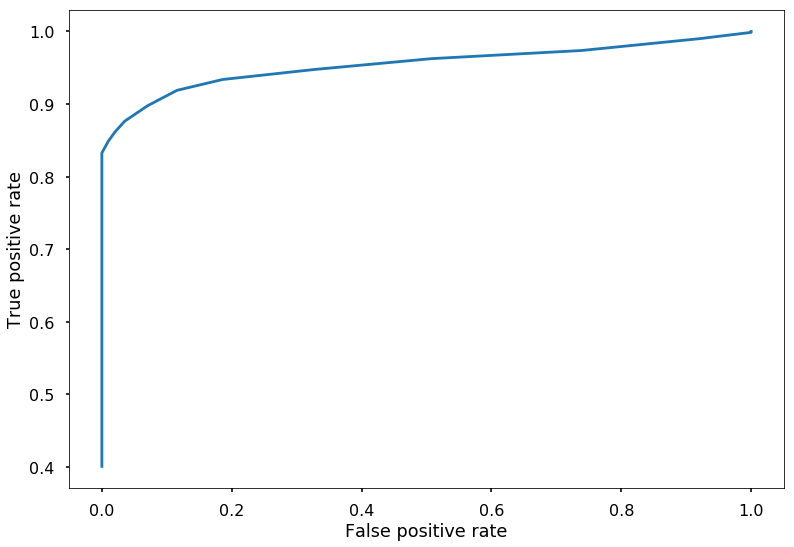

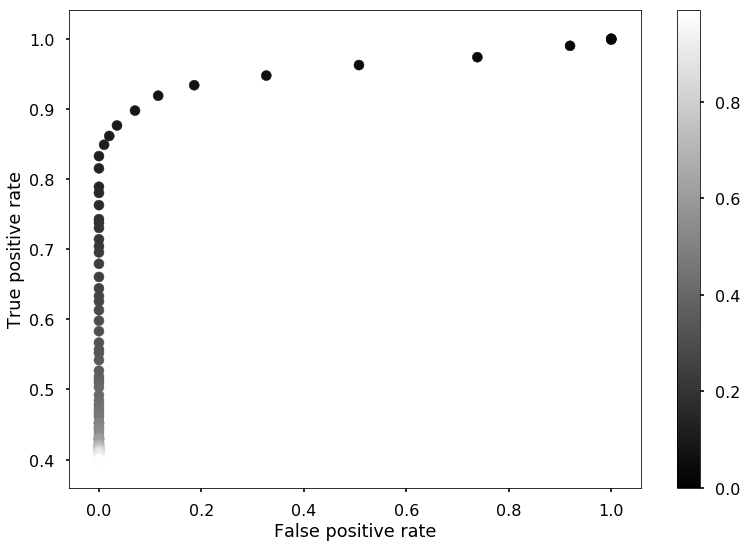

In [61]:
plt.plot(unspecificity, precision)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.scatter(unspecificity, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

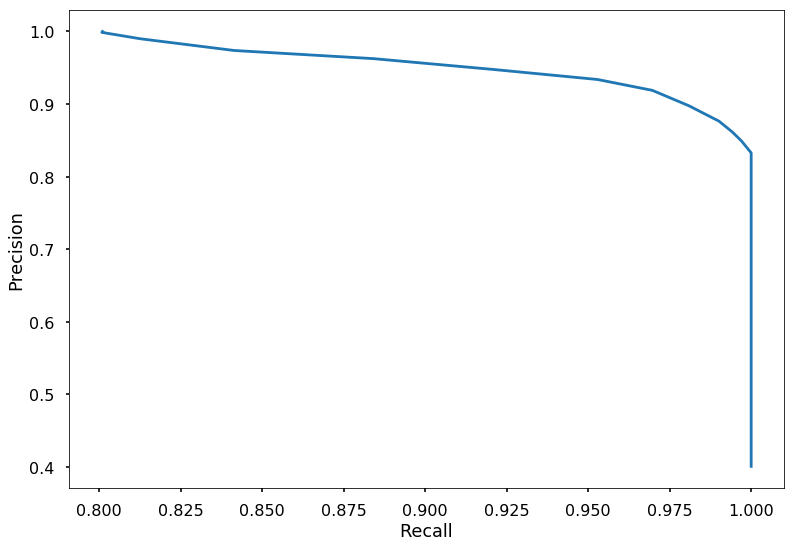

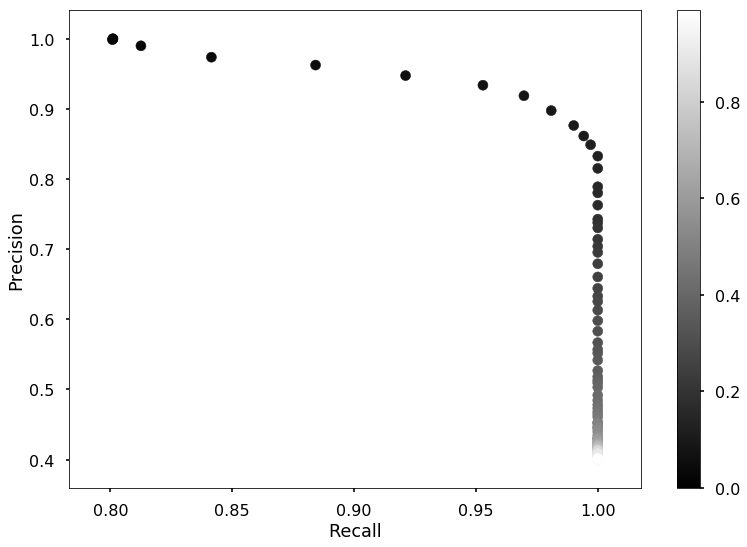

In [62]:
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

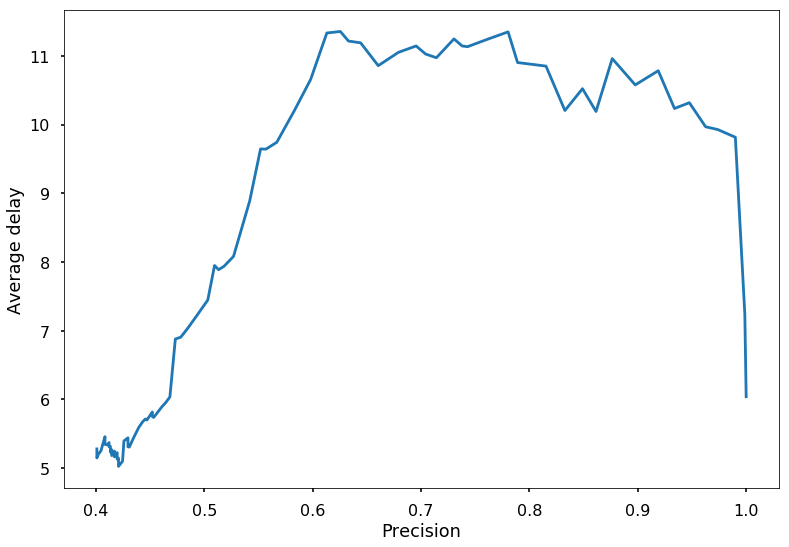

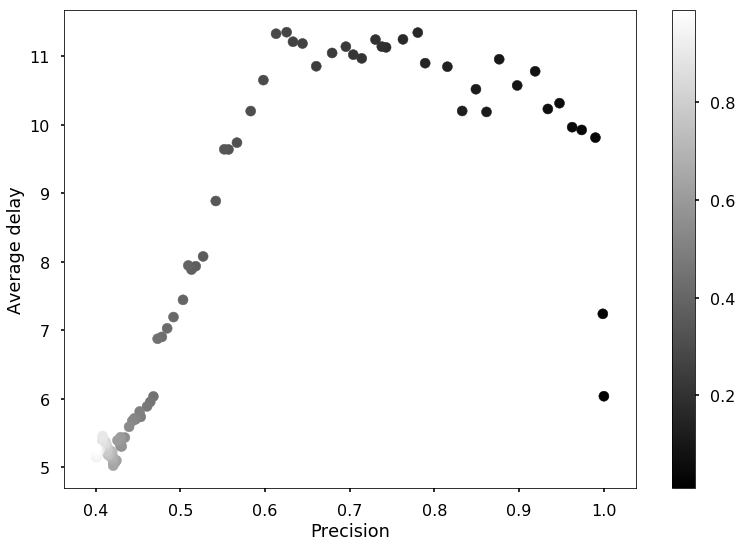

In [63]:
plt.plot([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

plt.scatter([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

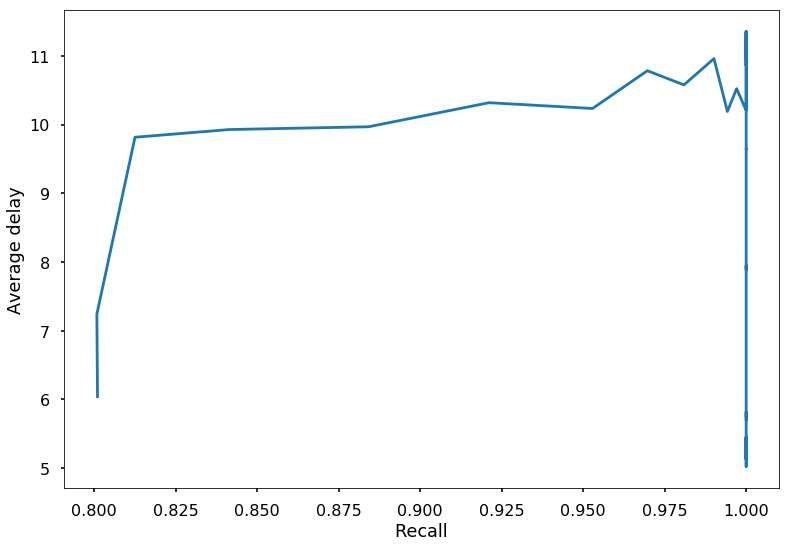

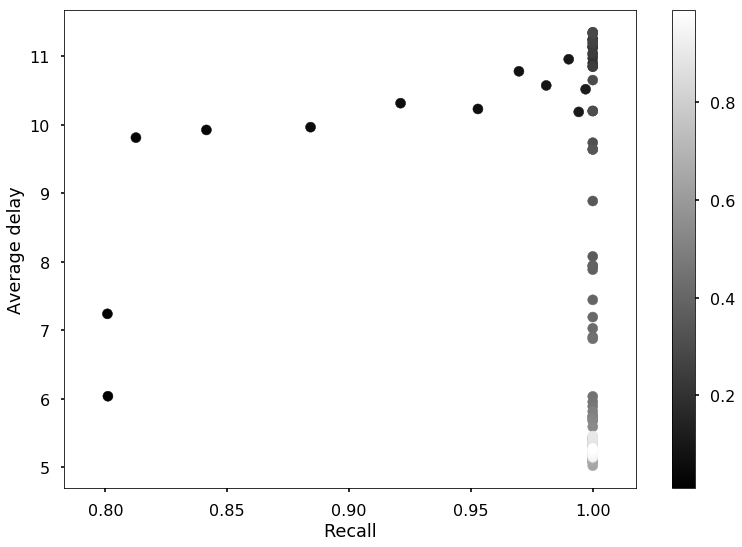

In [64]:
plt.plot([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

plt.scatter([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

## Проблема: непонятно какие значения порога выбирать для отрисовки ROC кривой и пр.

Идея: 
- генерируем $N$ рядов, по каждому из них считаем значение разладки
- считаем 95 квантиль (либо максимум) значения разладки $T$
- выбираем 100 порогов от нуля до $T$ с равномерным шагом

In [65]:
detection_values = []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
# threshold_max = max(detection_values)
# print('Threshold maximum is {}'.format(threshold_max))

threshold_max = np.percentile(detection_values, 95)
print('Threshold 95 percentile is {}'.format(threshold_max))

threshold_max = int(round(threshold_max,0))
print(threshold_max)

Threshold 95 percentile is 7.995439056091693
8


In [66]:
df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])
threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
act_temp, pred_temp, tr_temp = [], [], []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    for tr in threshold_list:
        cp_2 = cp_detection(cp_1, tr)
        act_temp.append(generated[1])
        pred_temp.append(cp_2)
        tr_temp.append(tr)
#         df_cp = df_cp.append({'actual': generated[1], 'predicted': cp_2, 'threshold': tr}, ignore_index=True)

df_cp = pd.DataFrame({'actual': act_temp, 'predicted': pred_temp, 'threshold': tr_temp})

In [67]:
precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    
    precision.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
    recall.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
    specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])
    
unspecificity = [1-x for x in specificity]

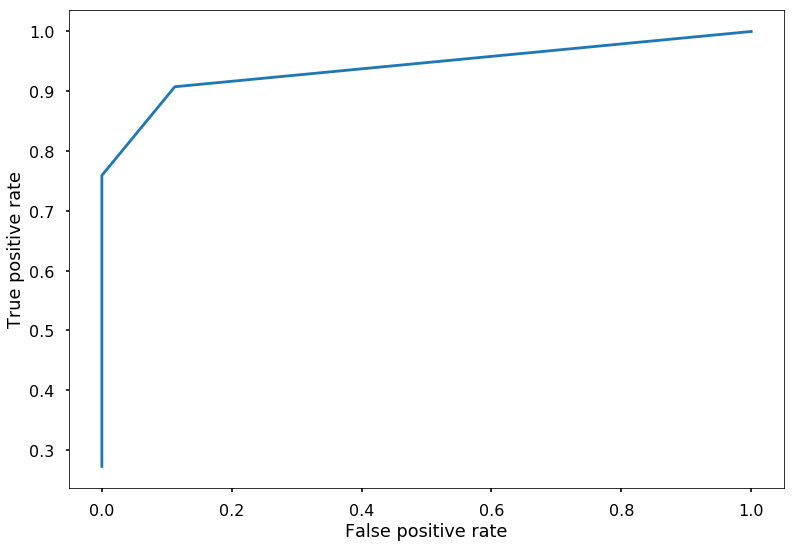

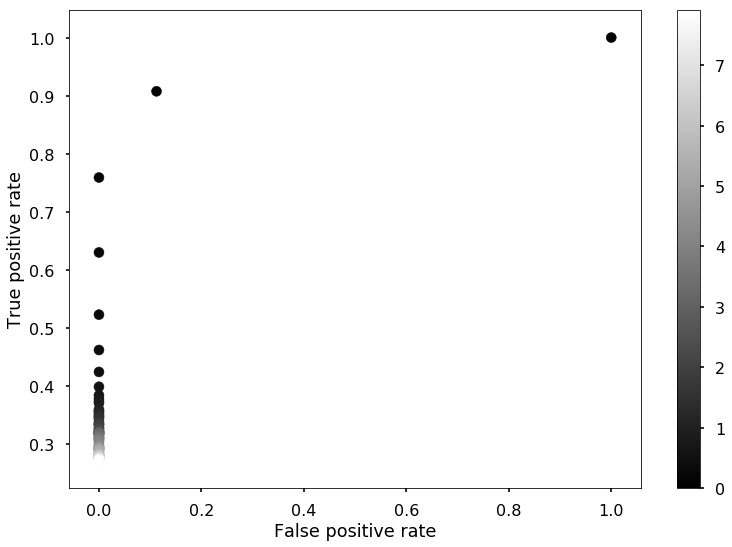

In [68]:
plt.plot(unspecificity, precision)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.scatter(unspecificity, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

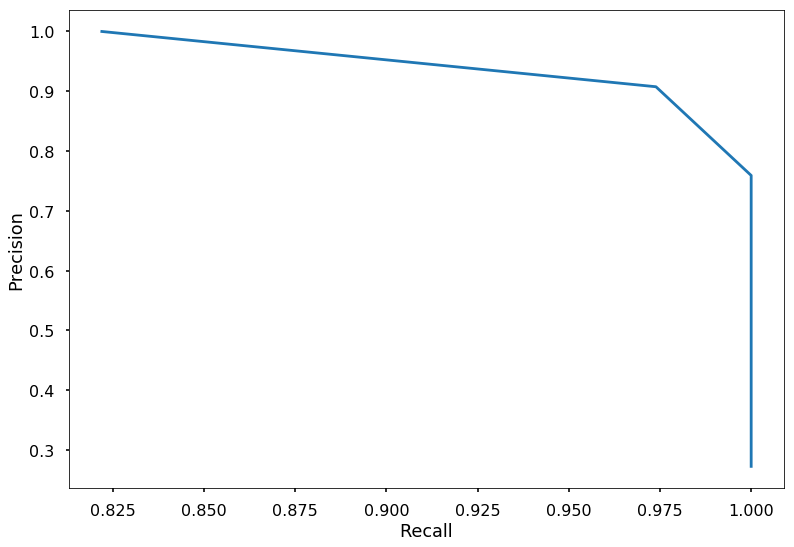

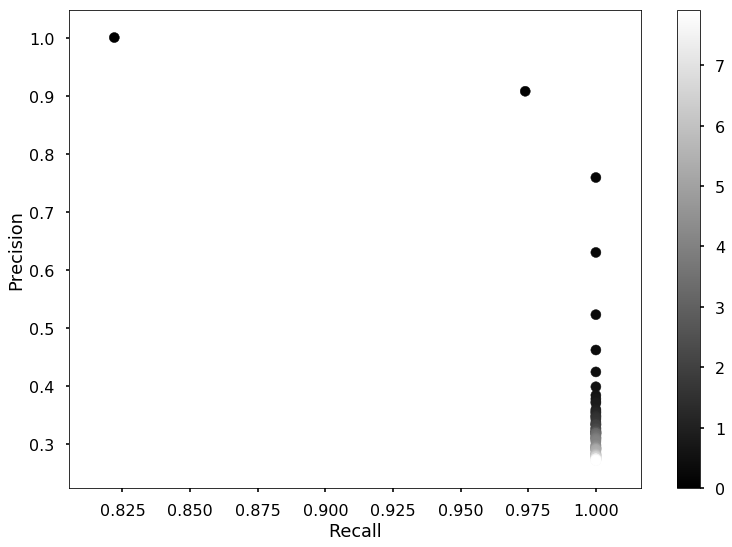

In [69]:
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

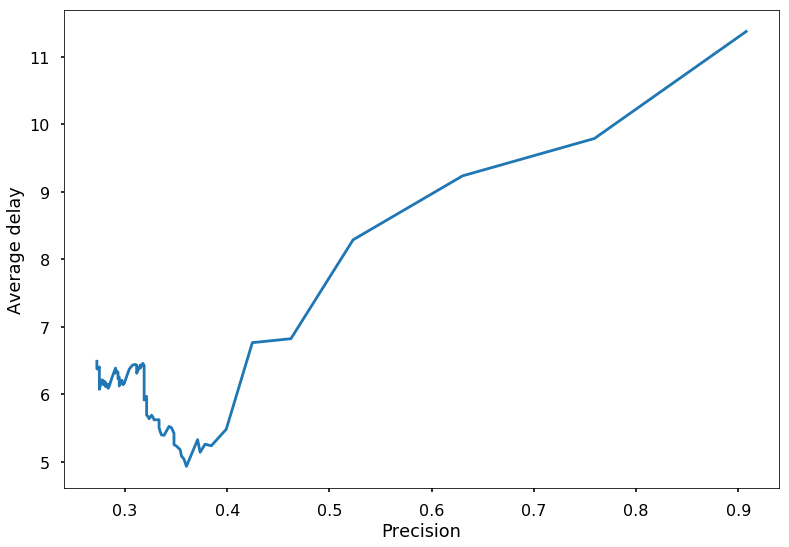

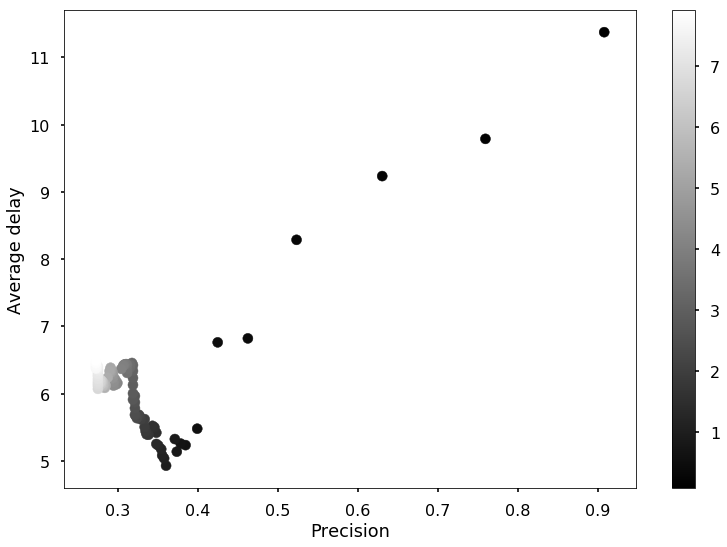

In [70]:
plt.plot([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

plt.scatter([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

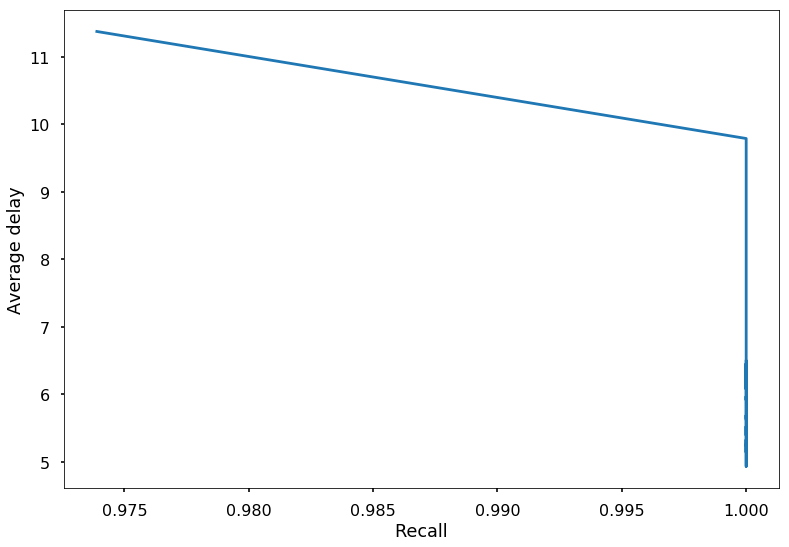

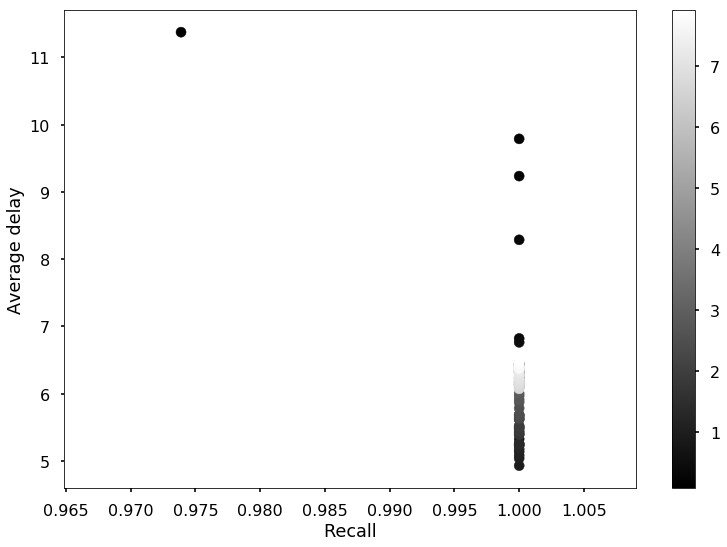

In [71]:
plt.plot([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

plt.scatter([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

### Попробуем без мультипликативности

In [72]:
detection_values = []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = False)
    cp_1 = approximation_mean(generated[0], 48)
    detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
# threshold_max = max(detection_values)
# print('Threshold maximum is {}'.format(threshold_max))

threshold_max = np.percentile(detection_values, 95)
print('Threshold 95 percentile is {}'.format(threshold_max))

# threshold_max = int(round(threshold_max,0))
# print(threshold_max)


df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])
threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
act_temp, pred_temp, tr_temp = [], [], []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    for tr in threshold_list:
        cp_2 = cp_detection(cp_1, tr)
        act_temp.append(generated[1])
        pred_temp.append(cp_2)
        tr_temp.append(tr)
#         df_cp = df_cp.append({'actual': generated[1], 'predicted': cp_2, 'threshold': tr}, ignore_index=True)

df_cp = pd.DataFrame({'actual': act_temp, 'predicted': pred_temp, 'threshold': tr_temp})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    
    precision.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
    recall.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
    specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])
    
unspecificity = [1-x for x in specificity]

Threshold 95 percentile is 0.21383820939872508


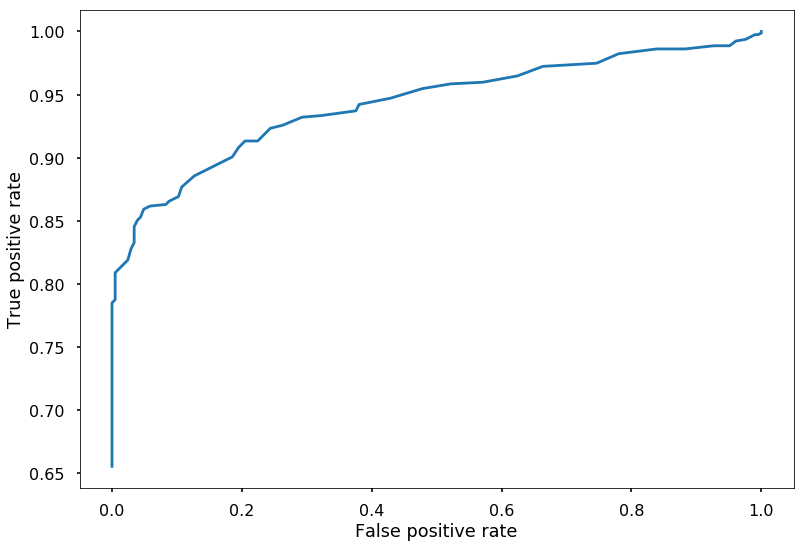

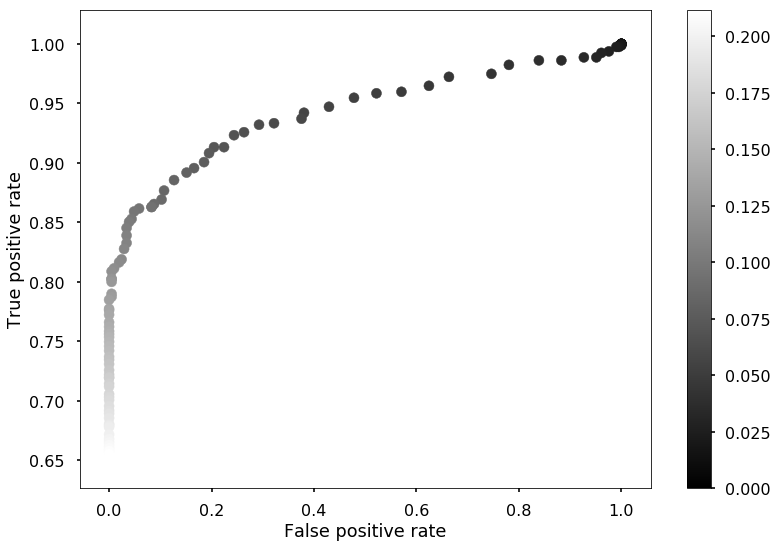

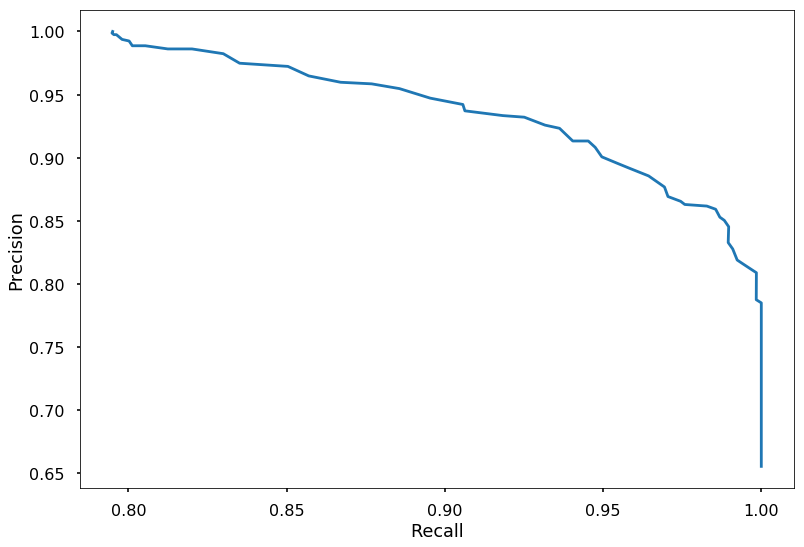

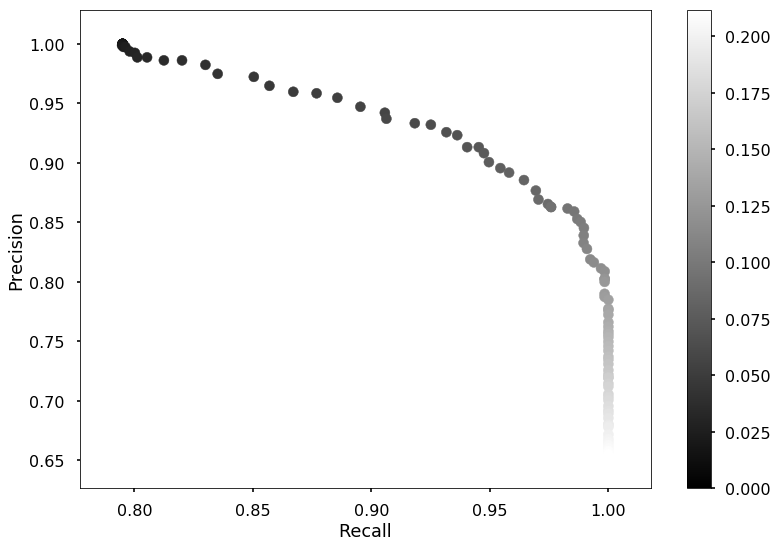

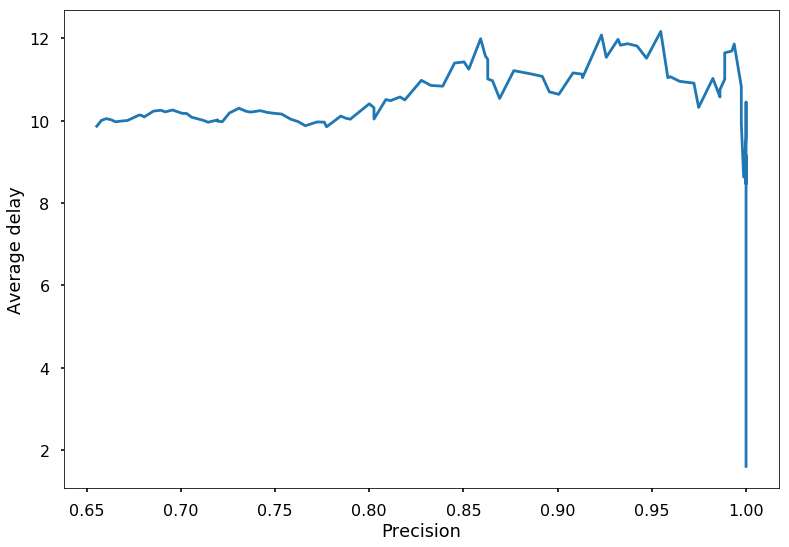

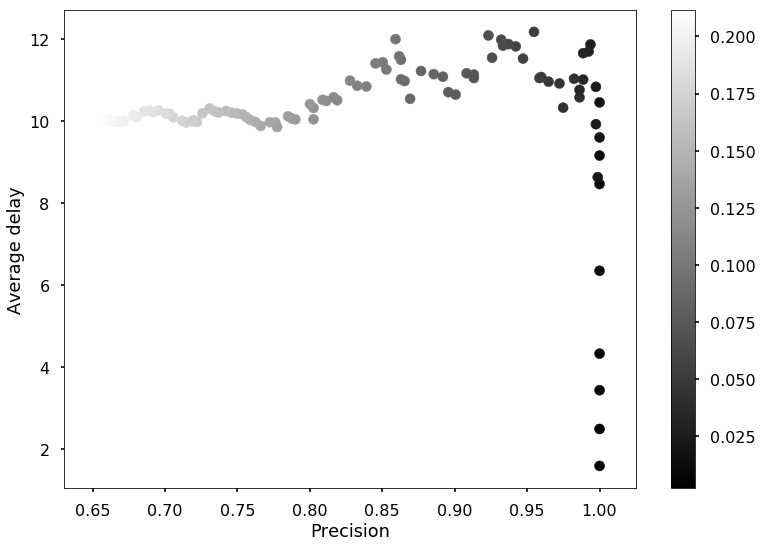

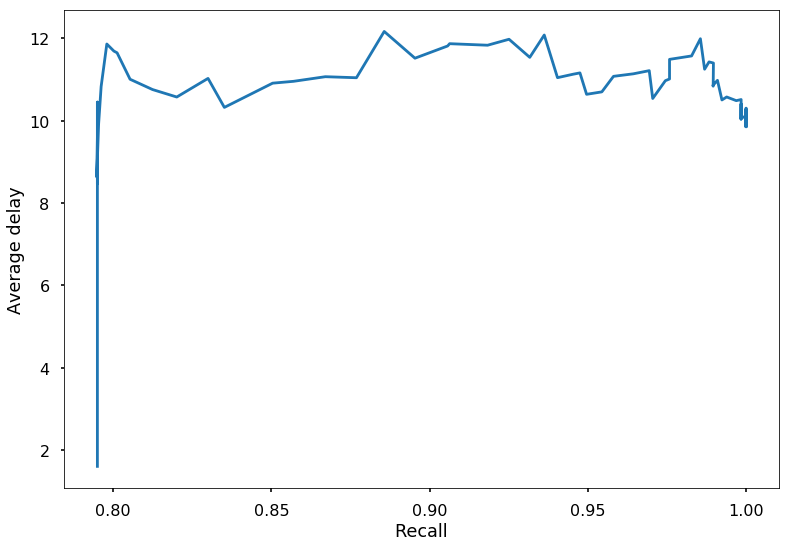

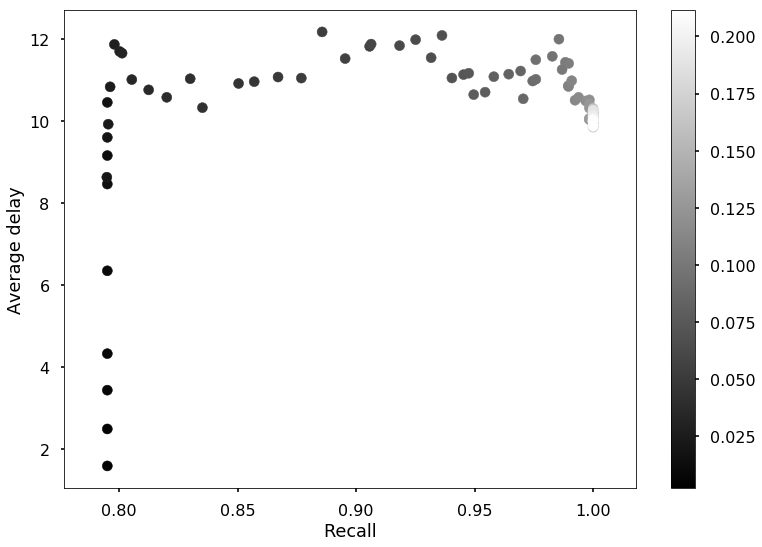

In [73]:
plt.plot(unspecificity, precision)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.scatter(unspecificity, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()


plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

plt.scatter([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

plt.plot([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

plt.scatter([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

